In [183]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import pandas as pd

coor_data = pd.read_csv('Data/coordata.csv')
date_data = pd.read_csv('Data/datedata.csv')
meta_data = pd.read_csv('Data/metadata.csv')
bus_stop_data = pd.read_csv('Data/bus_stop.csv')

# general = pd.read_csv('Data/ScooterData_July15_Sept27_2019.csv')

data_set = coor_data.join(bus_stop_data.join(date_data.join(meta_data)))


Y_data = data_set[['endx', 'endy']].to_numpy()
X_data = data_set.drop(columns=['endx', 'endy','start_date', 'end_near_stop']).to_numpy()

In [184]:
import progressbar

X_sets_by_day = []
Y_sets_by_day = []

hr = 0
x = []
y = []

compare_hr_before = 0
compare_hr_current = 0
for i in progressbar.progressbar(range(len(X_data))):
    compare_hr_current = data_set['start_hour'][i]
    if (compare_hr_before == 23 and compare_hr_current == 0):
        hr = 0
        X_sets_by_day.append(x)
        Y_sets_by_day.append(y)
        x = []
        y = []
    compare_hr_before = data_set['start_hour'][i]
    x.append(X_data[i])
    y.append(Y_data[i])
    if i == (len(X_data) - 1):
        X_sets_by_day.append(x)
        Y_sets_by_day.append(y)

100% (459478 of 459478) |################| Elapsed Time: 0:00:11 Time:  0:00:11


In [185]:
X_train_set = []
Y_train_set = []
for i in progressbar.progressbar(range(48)):
    for j in range(len(X_sets_by_day[i])):
        X_train_set.append(X_sets_by_day[i][j])
        Y_train_set.append(Y_sets_by_day[i][j])

X_test_set = []
Y_test_set = []
for i in progressbar.progressbar(range(48,len(X_sets_by_day))):
    for j in range(len(X_sets_by_day[i])):
        X_test_set.append(X_sets_by_day[i][j])
        Y_test_set.append(Y_sets_by_day[i][j])
        
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.callbacks import EarlyStopping

X_train_set = np.array(X_train_set)
X_test_set = np.array(X_test_set)
scx = MinMaxScaler(feature_range=(0,1))
X_train_set_fit = scx.fit_transform(X_train_set)
X_test_set_fit = scx.transform(X_test_set)

Y_train_set = np.array(Y_train_set)
Y_test_set = np.array(Y_test_set)
scy = MinMaxScaler(feature_range=(0,1))
Y_train_set_fit = scy.fit_transform(Y_train_set)
Y_test_set_fit = scy.transform(Y_test_set)

100% (48 of 48) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (27 of 27) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [195]:
for x in X_train_set_by_day:
    print(len(x))

54972
61793
69061
67357
74887
71611
59797


In [186]:
from tensorflow.keras import layers, Model, regularizers
from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
from copy import copy



X_train_set_by_day = []
Y_train_set_by_day = []
X_test_set_by_day = []
Y_test_set_by_day = []
models = []

for day in range(7):
    inputA = layers.Input(shape=(4))
    inputB = layers.Input(shape=(60))

    x = Dense(15)(inputA)
    x = Dense(30, activation="relu")(x)
    x = Model(inputs=inputA, outputs=x)
    y = Dense(62)(inputB)
    y = Dense(70, activation="relu")(y)
    y = Model(inputs=inputB, outputs=y)

    combined = layers.concatenate([x.output, y.output])

    final = Dense(70, activation="softmax")(combined)
    a = Dense(2)(final)
    
    X_train_set_by_day.append(X_train_set_fit[X_train_set[:,4] == day])
    Y_train_set_by_day.append(Y_train_set_fit[X_train_set[:,4] == day])
    X_test_set_by_day.append(X_test_set_fit[X_test_set[:,4] == day])
    Y_test_set_by_day.append(Y_test_set_fit[X_test_set[:,4] == day])
    model = Model(inputs=[x.input,y.input], outputs=a)
    models.append(model)
    models[day].compile(loss="mean_absolute_error", optimizer="adam")

# X_train_set_by_day.append(X_train_set_fit[X_train_set[:,4] < 5])
# Y_train_set_by_day.append(Y_train_set_fit[X_train_set[:,4] < 5])
# X_test_set_by_day.append(X_test_set_fit[X_test_set[:,4] < 5])
# Y_test_set_by_day.append(Y_test_set_fit[X_test_set[:,4] < 5])
# models.append(Model(inputs=[x.input,y.input], outputs=a))
# models[0].compile(loss="mean_absolute_error", optimizer="adam")

# X_train_set_by_day.append(X_train_set_fit[X_train_set[:,4] >= 5])
# Y_train_set_by_day.append(Y_train_set_fit[X_train_set[:,4] >= 5])
# X_test_set_by_day.append(X_test_set_fit[X_test_set[:,4] >= 5])
# Y_test_set_by_day.append(Y_test_set_fit[X_test_set[:,4] >= 5])
# models.append(Model(inputs=[x.input,y.input], outputs=a))
# models[1].compile(loss="mean_absolute_error", optimizer="adam")

In [187]:
def haversine(coord1: object, coord2: object):
    import math

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1, lat1 = coord1
    lon2, lat2 = coord2

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters, 5)
    km = round(km, 5)
    return km

In [188]:

x_train_old = []
y_train_old = []


# x_train = X_train_set_fit
# y_train = Y_train_set_fit
x_train = X_train_set_fit
y_train = Y_train_set_fit


for day in range(7):
    models[day].fit([x_train[:,0:4],x_train[:,4:]], y_train, epochs=50, verbose=2)

mae_rate_day = []
mae_rate_hour = np.zeros(24)
mae_count_hour = np.zeros(24)
for day in range(7):
    count_date_in_day = 0
    print('--------------------------------------: '+str(day))
    x_train = X_train_set_by_day[day]
    y_train = Y_train_set_by_day[day]
    models[day].fit([x_train[:,0:4],x_train[:,4:]], y_train, epochs=50, verbose=2)
    error_day_sum = []
    mae_rate_day.append(0)
    for i in range(48,75):
        if X_sets_by_day[i][0][4] == day:
            count_date_in_day = count_date_in_day + 1
            print('current at: '+str(i))
            x = scx.transform(X_sets_by_day[i])
            y = scy.transform(Y_sets_by_day[i])
            X_train_set_by_day[day] = np.concatenate((X_train_set_by_day[day], x), axis=0)
            Y_train_set_by_day[day] = np.concatenate((Y_train_set_by_day[day], y), axis=0)
            x_train = X_train_set_by_day[day]
            y_train = Y_train_set_by_day[day]
            
            ss = models[day].evaluate([x[:,0:4],x[:,4:]], y)

            result_Y = models[day].predict([x[:,0:4],x[:,4:]])
            result_Y_all = scy.inverse_transform(result_Y)
            y_test_all = scy.inverse_transform(y)

            error_all = 0            
            x_tr_hour = scx.inverse_transform(x)
            for i in (range(len(y_test_all))):
                error_all = error_all + haversine(result_Y_all[i],y_test_all[i])
            error_avg = error_all/len(y_test_all)
            print(round(error_avg, 3))
            mae_rate_day[day] = mae_rate_day[day] + error_avg
            
            
            for hr in range(24):
                mask = np.logical_and(x_tr_hour[:,3] > (hr)-0.2, x_tr_hour[:,3] < (hr+1)-0.2)
                result_Y_d = result_Y_all[mask]
                Y_test_in = y_test_all[mask]
                error_all = 0
                for i in (range(len(Y_test_in))):
                    error_all = error_all + haversine(result_Y_d[i],Y_test_in[i])
                error_avg = error_all/len(Y_test_in)
                mae_rate_hour[hr] = mae_rate_hour[hr] + error_avg
                mae_count_hour[hr] = mae_count_hour[hr] + 1
            
            history = models[day].fit([x_train[:,0:4],x_train[:,4:]], y_train, epochs=50, verbose=2)
            
    mae_rate_day[day] = mae_rate_day[day]/count_date_in_day
mae_rate_hour = mae_rate_hour/mae_count_hour[0]

Epoch 1/50
272446/272446 - 11s - loss: 0.0283
Epoch 2/50
272446/272446 - 10s - loss: 0.0189
Epoch 3/50
272446/272446 - 10s - loss: 0.0187
Epoch 4/50
272446/272446 - 10s - loss: 0.0186
Epoch 5/50
272446/272446 - 10s - loss: 0.0186
Epoch 6/50
272446/272446 - 11s - loss: 0.0185
Epoch 7/50
272446/272446 - 12s - loss: 0.0185
Epoch 8/50
272446/272446 - 10s - loss: 0.0184
Epoch 9/50
272446/272446 - 10s - loss: 0.0184
Epoch 10/50
272446/272446 - 11s - loss: 0.0184
Epoch 11/50
272446/272446 - 11s - loss: 0.0184
Epoch 12/50
272446/272446 - 11s - loss: 0.0184
Epoch 13/50
272446/272446 - 11s - loss: 0.0183
Epoch 14/50
272446/272446 - 12s - loss: 0.0184
Epoch 15/50
272446/272446 - 11s - loss: 0.0183
Epoch 16/50
272446/272446 - 11s - loss: 0.0183
Epoch 17/50
272446/272446 - 11s - loss: 0.0183
Epoch 18/50
272446/272446 - 10s - loss: 0.0183
Epoch 19/50
272446/272446 - 9s - loss: 0.0183
Epoch 20/50
272446/272446 - 8s - loss: 0.0183
Epoch 21/50
272446/272446 - 8s - loss: 0.0183
Epoch 22/50
272446/272446

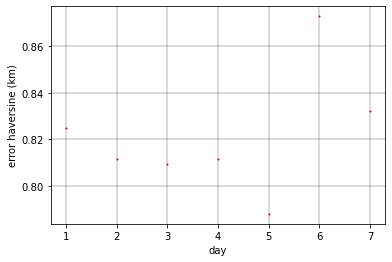

In [189]:
import matplotlib.pyplot as plt

plt.xlabel('day')
plt.ylabel('error haversine (km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter([1,2,3,4,5,6,7], mae_rate_day, color='r', s= 1)


In [192]:
sum(scat_plot)/len(scat_plot)

0.8222237255234649

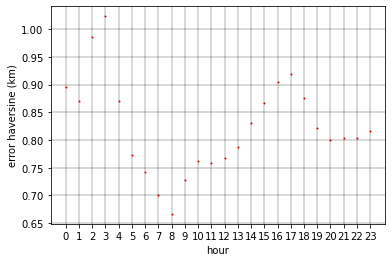

In [193]:
import matplotlib.pyplot as plt

plt.xlabel('hour')
plt.ylabel('error haversine (km)')
plt.grid(color='black', linestyle='-', linewidth=0.3)
plt.scatter(['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23'], mae_rate_hour, color='r', s= 1)

